In [272]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from PIL import Image
from matplotlib.backends.backend_agg import FigureCanvasAgg
import types
from tqdm import tqdm
from scipy.signal import medfilt, spline_filter
import scipy.fftpack as fftpack
from scipy import signal
from facenet_pytorch import MTCNN
from torch import device as device_
from torch import cuda
import warnings
from sklearn.decomposition import FastICA, PCA
warnings.filterwarnings("ignore")
import time

device = device_('cuda:0' if cuda.is_available() else 'cpu')

# Helpful functions

In [2]:
def show_image(img):
    Image.fromarray(img).show()

## COLOR MAGNIFICATION

In [3]:
def build_gaussian_pyramid(src,level=3):
    s=src.copy()
    pyramid=[s]
    for i in range(level):
        s=cv2.pyrDown(s)
        pyramid.append(s)
    return pyramid

def gaussian_video(video_tensor,levels=3):
    for i in range(0,video_tensor.shape[0]):
        frame=video_tensor[i]
        pyr=build_gaussian_pyramid(frame,level=levels)
        gaussian_frame=pyr[-1]
        if i==0:
            vid_data=np.zeros((video_tensor.shape[0],gaussian_frame.shape[0],gaussian_frame.shape[1],3))
        vid_data[i]=gaussian_frame
    return vid_data

def temporal_ideal_filter(tensor,low,high,fps,axis=0):
    fft=fftpack.fft(tensor,axis=axis)
    frequencies = fftpack.fftfreq(tensor.shape[0], d=1.0 / fps)
    bound_low = (np.abs(frequencies - low)).argmin()
    bound_high = (np.abs(frequencies - high)).argmin()
    fft[:bound_low] = 0
    fft[bound_high:-bound_high] = 0
    fft[-bound_low:] = 0
    iff=fftpack.ifft(fft, axis=axis)
    return np.abs(iff)   


def amplify_video(gaussian_vid,amplification=70):
    return gaussian_vid*amplification

def reconstract_video(amp_video,origin_video,levels=3):
    final_video=np.zeros(origin_video.shape)
    for i in range(0,amp_video.shape[0]):
        img = amp_video[i]
        for x in range(levels):
            img=cv2.pyrUp(img)
        img=cv2.resize(img, (origin_video[i].shape[1], origin_video[i].shape[0]))
        img=img+origin_video[i]
        final_video[i]=img
    return final_video    

def magnify_color(data_buffer,fps,low=0.4,high=2,levels=3,amplification=30):
    gau_video=gaussian_video(data_buffer,levels=levels)
    filtered_tensor=temporal_ideal_filter(gau_video,low,high,fps)
    amplified_video=amplify_video(filtered_tensor,amplification=amplification)
    final_video=reconstract_video(amplified_video,data_buffer,levels=levels)
    #print("c")
    return final_video

## Color notmalization and avg. color signal

In [129]:
def image_normalization(img):
    img -= np.min(img)
    img /= np.max(img)
    img *= 255
    img = img.astype(np.uint8)
    return img


def get_avg_color_signal(frames, channel=1):
    return np.array([frame[:, :, channel].mean() for frame in frames])

# Process video

In [428]:
mtcnn = MTCNN(image_size=200, device=device, selection_method="probability")


def extract_face_from_image(image: np.array):
    # Image.fromarray(image).show()
    res = mtcnn.detect(image)
    if res[0] is None: return None
    box = res[0][0].astype(int)
    y1, y2, x1, x2 = box[1], box[3], box[0], box[2]
    # Image.fromarray(image[y1:y2, x1:x2]).show()
    return image[y1:y2, x1:x2]

def extract_frame_from_video(path: str, frame_idx_start=1, frame_idx_end=None, step=1):
    faces = {}
    cap = cv2.VideoCapture(path)
    fps = cap.get(cv2.CAP_PROP_FPS)
    length = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    if frame_idx_end is not None and frame_idx_end > length: length = frame_idx_end
    print(f"Количество кадров: {length}\t ФПС: {fps:.2f}")
    
    for i in tqdm(range(1, length + 1)):
        ret, img = cap.read()
        #show_image(img)
        #return
        if not ret:
            break
        if i >= frame_idx_start:
            if int(i - 1) % step == 0:
                face = extract_face_from_image(img)
                if face is None: print(i, 'None')
                faces[i] = {'FullFace': face, 'Time': (1 / fps) * (i - 1)}
    fps /= step
    print(f"Новое количество кадров: {len(faces.keys())}\t Новый ФПС: {fps:.2f}")
    return faces, fps, length

In [96]:
step = 5
faces_dict, fps, length = extract_frame_from_video('files/id16_0013.mp4', 1, step=step)

  0%|                                                  | 0/411 [00:00<?, ?it/s]

Количество кадров: 411	 ФПС: 29.95


100%|████████████████████████████████████████| 411/411 [01:00<00:00,  6.79it/s]

Новое количество кадров: 83	 Новый ФПС: 5.99


## Drop None-frames and resize all frames to one shape

In [97]:
def fill_None(faces_dict: dict):
    filled = 0
    prev = None
    next_ = None
    keys = [key for key in faces_dict]
    
    for key in keys:
        if faces_dict[key]['FullFace'] is None:
            if prev is not None:
                filled += 1
                faces_dict[key]['FullFace'] = prev.copy()
        else:
            prev = faces_dict[key]['FullFace']

    keys.reverse()
    for key in keys:
        if faces_dict[key]['FullFace'] is None:
            if next_ is not None:
                filled += 1
                faces_dict[key]['FullFace'] = next_.copy()
        else:
            next_ = faces_dict[key]['FullFace']
            
    if prev is None and next_ is None:
        raise "Нет ни единого кадра с лицом!!!"
    
    print(filled)
    
    pass


def resize_images_to_one_shape(faces_dict: dict, shape=None):
    if shape is None:
        shapes = []
        for key in faces_dict:
            shapes += [faces_dict[key]['FullFace'].shape[:2]]
        shape = np.mean(shapes, axis=0).astype(int)
    for key in faces_dict:
        faces_dict[key]['FullFace'] = cv2.resize(faces_dict[key]['FullFace'], (shape[1], shape[0]))
    pass


fill_None(faces_dict)
resize_images_to_one_shape(faces_dict)

0


In [8]:
show_image(faces_dict[1]['FullFace'])

## Create ROI areas

In [98]:
def create_ROI_using_size(image, height, width, left_shift=0.1, right_shift=0.1,
                          top_shift=0.1, bottom_shift=0.1, rectangled_image=None, show=False):
    shift_right_left = (int(left_shift * width), int(width - right_shift * width))
    shift_top_bottom = (int(top_shift * height), int(height - bottom_shift * height))
    if rectangled_image is None: rectangled_image = image.copy()
    rectangled_image = cv2.rectangle(rectangled_image,
                                    (shift_right_left[0], shift_top_bottom[0]),
                                    (shift_right_left[1], shift_top_bottom[1]),
                                    (255, 0, 0), 5)
    if show: Image.fromarray(rectangled).show()
    return image[shift_top_bottom[0]:shift_top_bottom[1], shift_right_left[0]:shift_right_left[1]], rectangled_image

def create_ROI(faces_dict: dict):
    for key in faces_dict.keys():
        fullface = faces_dict[key]['FullFace']
        # print(fullface.shape)
        left_cheek, _ = create_ROI_using_size(fullface, *fullface.shape[:2], 0.15, 0.7, 0.5, 0.4)
        right_cheek, _ = create_ROI_using_size(fullface, *fullface.shape[:2], 0.7, 0.15, 0.5, 0.4, _)
        forehead, _ = create_ROI_using_size(fullface, *fullface.shape[:2], 0.3, 0.3, 0.1, 0.8, _)
        faces_dict[key]['Forehead'] = forehead
        faces_dict[key]['LeftCheek'] = left_cheek
        faces_dict[key]['RightCheek'] = right_cheek
        faces_dict[key]['Rectangled'] = _

create_ROI(faces_dict)

In [10]:
show_image(faces_dict[1]['Rectangled'])

# Main algorithm

In [269]:
import time

def fourier_for_norm_signal(mean_signal_norm, fps):
    L = len(mean_signal_norm)
    
    raw = np.fft.rfft(mean_signal_norm * 30)  # do real fft with the normalization multiplied by 10
    freqs_ = float(fps) / L * np.arange(L // 2 + 1)
    freqs = 60. * freqs_

    fft = np.abs(raw) ** 2  # get amplitude spectrum
    # plot(freqs, fft, 'freq', 'Fourier before pruning')

    idx = np.where((freqs > 50) & (freqs < 180))  # the range of frequency that HR is supposed to be within
    pruned = fft[idx]
    pfreq = freqs[idx]

    freqs_ = pfreq
    fft = pruned
    # plot(pfreq, fft, 'freq', 'Fourierr after pruning')
    fft = [pfreq, fft]
    idx = np.argmax(pruned)  # max in the range can be HR
    # print(fft[0][idx])
    heart_rate = fft[0][idx]
    return fft, heart_rate


def calculate_pulse_in_buffer(buffer, L, fps, channel):
    ## Обработка кадров видео ##
    magnified_ROI = magnify_color(buffer,fps,low=0.4,high=2,levels=3,amplification=50)
    #print(magnified_ROI.shape)
    mean_signal = get_avg_color_signal(magnified_ROI, channel)
    # time.sleep(0.02)
    #print(mean_signal.shape)

    ## Делаем сигнал более переодичным ##
    # Проблемы, что память не успевает выделяться
    try:
        detrend = signal.detrend(mean_signal)
    except:
        time.sleep(0.1)
        detrend = signal.detrend(mean_signal)
    time_range = np.array([1 / fps * i for i in range(L)])
    interpolated = np.interp(time_range, time_range, detrend)  # interpolation by 1
    interpolated = np.hamming(L) * interpolated  # make the signal become more periodic
    mean_signal_norm = interpolated / np.linalg.norm(interpolated)
    
    ## Фурье ##
    fft, heart_rate = fourier_for_norm_signal(mean_signal_norm, fps)
    return mean_signal, mean_signal_norm, fft, heart_rate


def algorithm(faces_dict, fps, idx_start=1, idx_end=1000, area='FullFace', channel=1):
    idx_array = np.array([key for key in faces_dict.keys()]).astype(str).astype(int)
    idx_array = idx_array[(idx_array < idx_end) & (idx_array >= idx_start)]
    
    L = len(idx_array)

    buffer = np.array([faces_dict[i][area].copy() for i in idx_array])
    # print(buffer.shape)

    mean_signal, mean_signal_norm, fft, heart_rate = calculate_pulse_in_buffer(buffer, L, fps, channel)
    
    return mean_signal, mean_signal_norm, fft, heart_rate

In [375]:
def visualize_f(faces_dict, mean_signals_norm, fft, areas, fps, filename='tmp', speedx=0.25):
    for area in areas:
        frames_to_save = []
        keys = [int(key) for key in mean_signals_norm.keys()]
        fig = plt.figure(figsize=(5, 10), dpi=100)
        for key in tqdm(keys):
            plt.subplot(3, 1, 1)
            plt.title(f"Кадр: {key}, размер буфера: {buff_size}")
            plt.imshow(faces_dict[key]['Rectangled'].copy())
            plt.xticks([])
            plt.yticks([])
            plt.subplot(3, 1, 2)
            plt.plot(mean_signals_norm[key][area])
            plt.legend(['Signal'], loc=1)
            plt.xticks([])
            plt.yticks([])
            plt.subplot(3, 1, 3)
            plt.plot(fft[key][area][0], fft[key][area][1])
            plt.legend(['Fourier'], loc=1)
            canvas = FigureCanvasAgg(fig)
            s, (width, height) = canvas.print_to_buffer()
            X = np.fromstring(s, np.uint8).reshape((height, width, 4))
            # display(fig)
            plt.clf()
            # clear_output(wait=True)
            X = cv2.cvtColor(X, cv2.COLOR_RGBA2BGR)
            frames_to_save += [X[80:-80]]
        save_video(frames_to_save, filename, area, fps, 0.2)


def save_video(all_imgs, filename, area, fps, save_speedx):
    all_imgs = np.array(all_imgs).astype(np.uint8)
    out = cv2.VideoWriter(filename + area + '_pulse.avi',
                          cv2.VideoWriter_fourcc(*'MJPG'),
                          int(fps * save_speedx),
                          (all_imgs[0].shape[1], all_imgs[0].shape[0]))
    print("========== Save File ==========")
    for im in tqdm(all_imgs):
        out.write(im)
    out.release()

In [421]:
visualize = True
areas = ['LeftCheek', 'RightCheek', 'FullFace', 'Forehead']

mean_signals_norm = {}
fft = {}
heart_rates = {}
buff_size = 50


print('<===== Process signal =====>')
for i in tqdm(range(buff_size + 1, length, step)):
    mean_signals_norm[i] = {}
    fft[i] = {}
    heart_rates[i] = {}
    for area in areas:
        mean_signal, mean_signals_norm[i][area], fft[i][area], heart_rates[i][area] = algorithm(faces_dict, fps,
                                                                                                i-buff_size, i,
                                                                                                area, 1)

print('<===== Visualize =====>')
if visualize is True: visualize_f(faces_dict, mean_signals_norm, fft, areas, fps, filename='tmp', speedx=0.25)

  1%|▌                                          | 1/72 [00:00<00:11,  6.33it/s]

<===== Process signal =====>


  1%|▌                                          | 1/72 [00:00<00:09,  7.30it/s]

<===== Visualize =====>


 44%|██████████████████▏                      | 32/72 [00:00<00:00, 316.76it/s]

========== Save File ==========


 46%|██████████████████▊                      | 33/72 [00:00<00:00, 323.46it/s]

========== Save File ==========


 44%|██████████████████▏                      | 32/72 [00:00<00:00, 316.76it/s]

========== Save File ==========


 46%|██████████████████▊                      | 33/72 [00:00<00:00, 323.46it/s]

========== Save File ==========


100%|█████████████████████████████████████████| 72/72 [00:00<00:00, 322.80it/s]


<Figure size 500x1000 with 0 Axes>

<Figure size 500x1000 with 0 Axes>

<Figure size 500x1000 with 0 Axes>

<Figure size 500x1000 with 0 Axes>

In [426]:
def apply_FastICA(mean_signals_norm, fps, n_components: int, filename='tmp'):
    assert n_components > 0
    
    #     plt.subplot(2, 1, 1)
    #     plt.bar(*np.unique(hearts_rate, return_counts=True), 5)
    
    pca = FastICA(n_components)
    H = pca.fit_transform(mean_signals_norm)
    
    plt.figure(figsize=(10, 5), dpi=100)
    plt.subplot(2, 2, 3)
    plt.plot(H)
    
    plt.subplot(2, 2, 4)
    if n_components == 1:
        fft, heart_rate = fourier_for_norm_signal(H, fps)
        plt.title(heart_rate)
        plt.plot(fft[0], fft[1])
    else:
        for i in range(n_components):
            H_ = H[:, i]
            fft, heart_rate = fourier_for_norm_signal(H_, fps)
            plt.title(heart_rate)
            plt.plot(fft[0], fft[1])
    plt.savefig(filename + '.png')
    plt.show()
    
    del pca

<===== Apply FastICA =====>


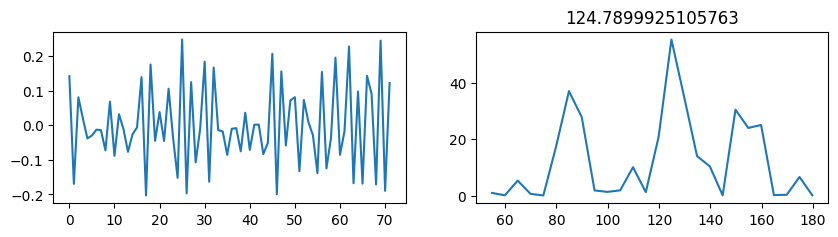

<===== Apply FastICA =====>


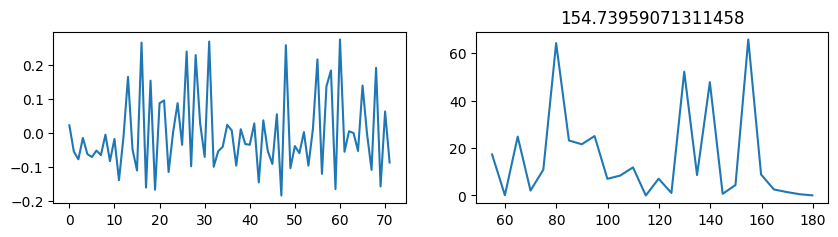

<===== Apply FastICA =====>


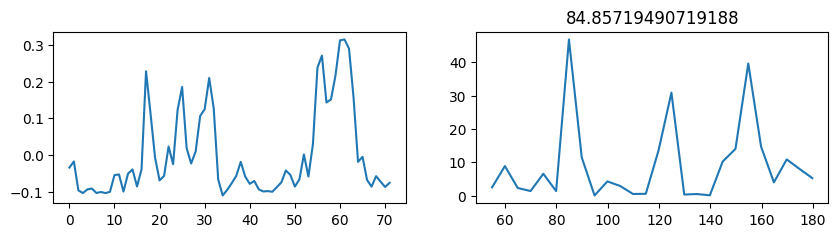

<===== Apply FastICA =====>


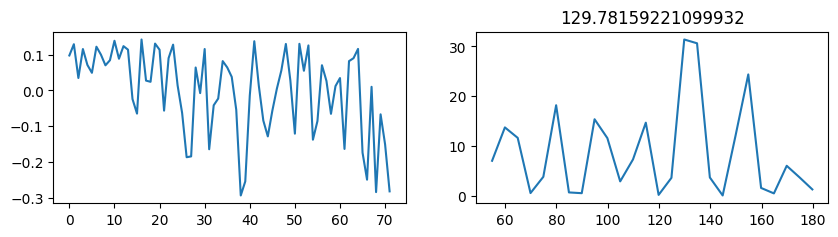

In [427]:
mean_signals = []
areas_for_ICA = ['FullFace', 'Forehead', 'LeftCheek', 'RightCheek']
for area in areas_for_ICA:
    mean_signals = [mean_signals_norm[key][area] for key in mean_signals_norm.keys()]
    print('<===== Apply FastICA =====>')
    apply_FastICA(mean_signals, fps, 1, 'FastICA'+area)